Idea here is to estimate the distribution of ImageNet in the frequency domain, so we can then generate random images with the same distribution.

Running this notebook generates `result.pt` which holds the distribution for 224x224 input images


In [135]:
import torch
import torchvision.datasets
from torchvision import transforms
from utils import tpeek, itpeek
torch.cuda.is_available()

True

In [136]:
mean_std = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

W = 224
H = 224

data = torchvision.datasets.ImageNet('.', split='val', transform=transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),  # Converts to CHW
    transforms.Normalize(**mean_std),    
]))

In [146]:
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, num_workers=4)
loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


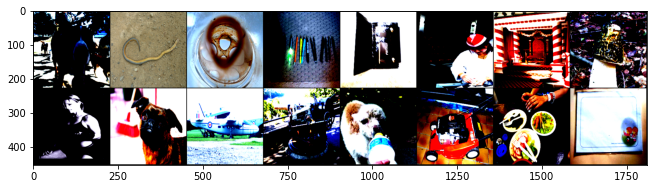

In [159]:
# Sanity check that we're loading images correctly.

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt

def imshow(t):
    return plt.imshow(t.permute(1, 2, 0))


class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
 
images, target = iter(loader).next()
DeNormalize(**mean_std)(images[1])
fig = plt.figure(figsize=(11, 11))
grid_img = torchvision.utils.make_grid(images[:16], nrow=8)
imshow(grid_img)

In [148]:
# CM: still not understanding why this 113 is right on a 224 image
total = torch.zeros((3, H, 113), dtype=torch.float64)
total2 = torch.zeros_like(total)
count = 0
for i, (images, target) in zip(range(50), loader):
    # This takes the FFT across width and height only (broadcasting over batch and channel)
    freq = torch.fft.rfft2(images)
    mag = freq.abs()  # sqrt(real**2 + imag**2)
    total += mag.sum(0)
    total2 += (mag ** 2).sum(0)
    count += len(images)
result = total / count
result2 = total2 / count
print(result.mean(), result.std(), count)

tensor(59.5630, dtype=torch.float64) tensor(260.8215, dtype=torch.float64) 12800


In [157]:
result[0, :8, :8].round()

tensor([[24487., 10047.,  5341.,  3575.,  2680.,  2110.,  1757.,  1506.],
        [12626.,  5951.,  3674.,  2625.,  1998.,  1602.,  1337.,  1138.],
        [ 6723.,  3744.,  2632.,  1996.,  1591.,  1313.,  1110.,   955.],
        [ 4345.,  2658.,  1991.,  1583.,  1309.,  1108.,   955.,   835.],
        [ 3251.,  2019.,  1567.,  1309.,  1094.,   960.,   832.,   741.],
        [ 2572.,  1609.,  1289.,  1096.,   945.,   834.,   729.,   663.],
        [ 2117.,  1350.,  1090.,   936.,   823.,   735.,   665.,   596.],
        [ 1799.,  1138.,   940.,   815.,   728.,   652.,   595.,   539.]],
       dtype=torch.float64)

In [187]:
(100 / inv).round()[0]

tensor([[22400., 22400., 11200.,  ...,   204.,   202.,   200.],
        [22400., 15839., 10018.,  ...,   204.,   202.,   200.],
        [11200., 10018.,  7920.,  ...,   204.,   202.,   200.],
        ...,
        [ 7467.,  7084.,  6213.,  ...,   204.,   202.,   200.],
        [11200., 10018.,  7920.,  ...,   204.,   202.,   200.],
        [22400., 15839., 10018.,  ...,   204.,   202.,   200.]],
       dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


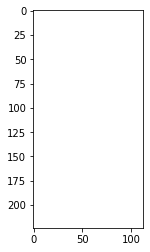

In [182]:
import numpy as np
height = 224
width = 224
y_freqs = np.fft.fftfreq(height)[:, None]  # (224,) (224,1)
x_freqs = np.fft.fftfreq(width)[: ((width + 1) // 2) + 1]  # (113,)
freqs = np.sqrt(x_freqs ** 2 + y_freqs ** 2)
freqs[0, 0] = 1.0 / max(width, height)
freqs = torch.tensor(freqs)
inv = torch.stack([freqs, freqs, freqs])
imshow(1 / inv)


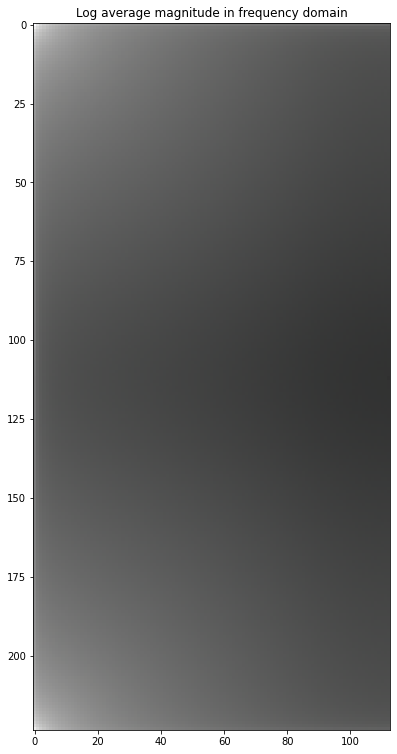

In [166]:
# Visualize on log scale
r = result.log()
r /= r.max()
plt.figure(figsize=(13, 13))
plt.title('Log average magnitude in frequency domain')
imshow(r)

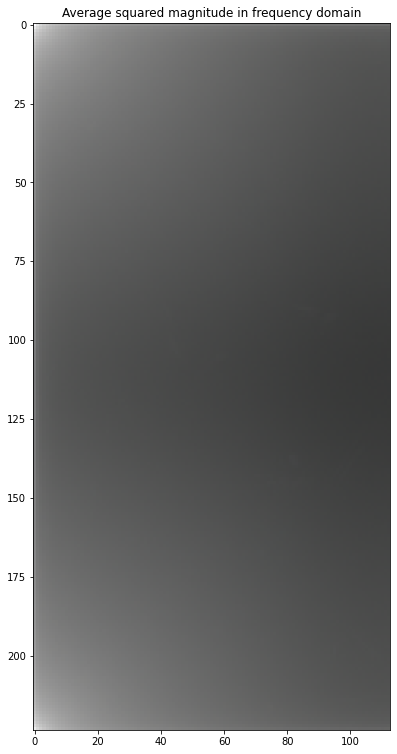

In [168]:
r = result2.log()
r /= r.max()
plt.figure(figsize=(13, 13))
plt.title('Average squared magnitude in frequency domain')
imshow(r)

In [152]:
torch.save(result, 'result.pt')
torch.save(result2, 'result2.pt')